<a href="https://colab.research.google.com/github/onolf/guarani-rag-2025/blob/main/guarani_pln_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROYECTO FINAL: Generación de Texto Sintético en Guaraní mediante Transformaciones Gramaticales**
## **Comparativa: LLM Prompting (sin RAG) vs. Sistema RAG**
**Diplomado en NLP & IA – FPUNA 2025**

**Integrante:**
* Odilón Nolf Sánchez

**Repositorio GitHub:** [guarani-rag-2025](https://github.com/onolf/guarani-rag-2025)

---

### **1. Entendimiento del Negocio (Business Understanding)**
**Necesidad:** Generar texto sintético en guaraní aplicando transformaciones gramaticales precisas (tiempos verbales, persona, nasalización, posesivos, etc.) para la preservación lingüística y la educación.

**Problema:** Existe una escasez de recursos digitales en guaraní, lo que provoca un alto riesgo de "alucinaciones" (errores gramaticales o inventos) cuando se utilizan LLMs puros sin contexto externo.

**Solución Propuesta:** Implementar una arquitectura RAG (Retrieval-Augmented Generation) que utilice documentos gramaticales y diccionarios oficiales para fundamentar las respuestas del modelo.

In [17]:
# Contenido de requirements.txt:
# chainlit==2.9.2
# ... (y el resto de tus dependencias)

# Instalación de librerías y dependencias necesarias
!pip install -r requirements.txt
!pip install pandas matplotlib requests openrouter langchain langchain-community langchain-huggingface langchain-text-splitters faiss-cpu

# Importaciones para el notebook
import os
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import StringIO
from langchain_community.document_loaders import PyPDFLoader, DirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI # Usaremos el wrapper ChatOpenAI para OpenRouter
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
# Importaciones para el cálculo de latencia
import time

### **2. Entendimiento de los Datos (Data Understanding)**

**Fuentes de Datos:**
* **Diccionario Guaraní-Español:** Documento PDF (aprox. 218 páginas) con vocabulario esencial.
* **Gramática Guaraní:** Documento PDF (aprox. 260 páginas) con reglas de aglutinación, nasalización y tiempos verbales.

A continuación, cargamos los documentos para su análisis inicial.

In [18]:
from google.colab import drive
drive.mount('/content/drive')
path_docs = "/content/drive/My Drive/Datos_Guarani/"

print("Cargando documentos PDF desde Google Drive...")

# Ensure the directory exists before loading
if not os.path.exists(path_docs):
    print(f"Advertencia: La carpeta '{path_docs}' no existe en Google Drive. Asegúrate de que los PDFs estén allí.")
    docs = [] # Initialize empty if folder not found
else:
    loader = DirectoryLoader(path_docs, glob="*.pdf", loader_cls=PyPDFLoader)
    docs = loader.load()

print(f"Se han cargado {len(docs)} páginas/fragmentos de documentos.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cargando documentos PDF desde Google Drive...
Se han cargado 478 páginas/fragmentos de documentos.


# **Análisis Exploratorio de Datos (EDA)**

En proyectos de NLP, el análisis exploratorio se centra en entender la longitud de los textos, la distribución de palabras y la calidad del contenido extraído.

Estadísticas de longitud de caracteres por página/fragmento:
count     478.000000
mean     1624.173640
std       810.526553
min         0.000000
25%      1004.000000
50%      1387.500000
75%      2360.000000
max      4226.000000
Name: length, dtype: float64


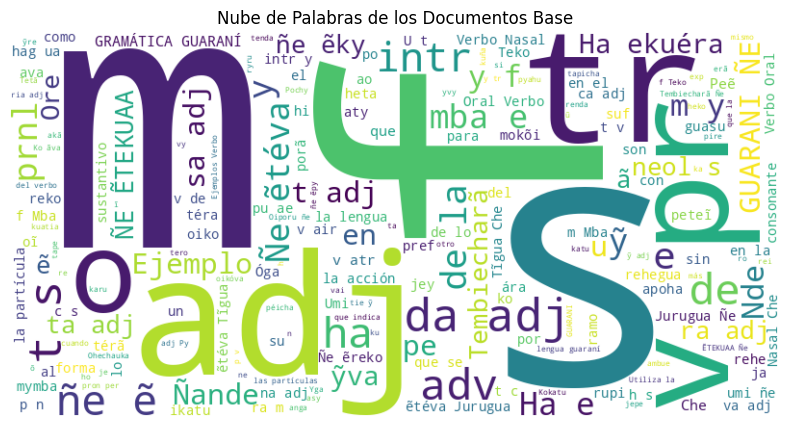

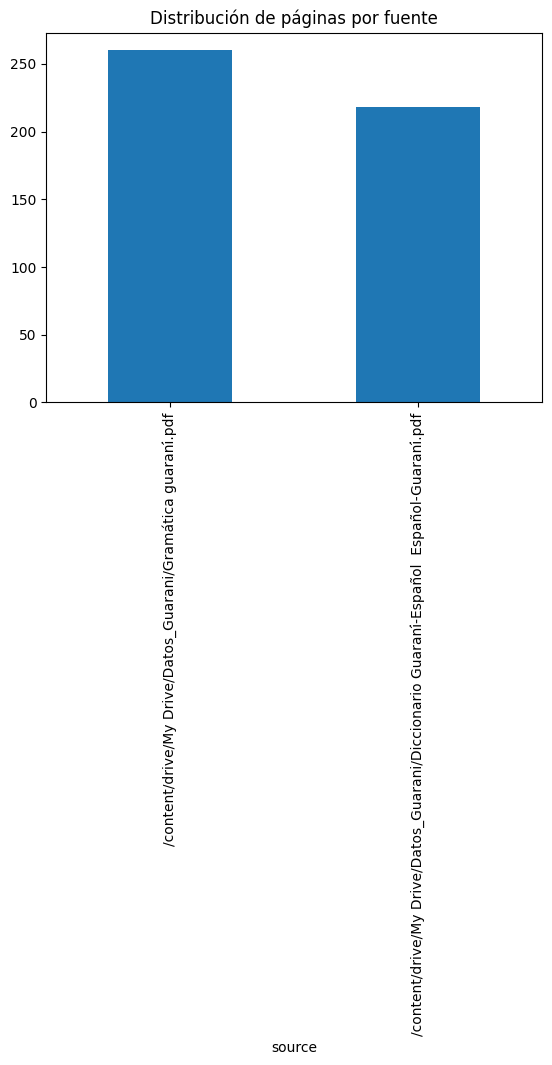

In [14]:
# Crear un DataFrame para análisis
data = [{"content": d.page_content, "source": d.metadata["source"], "length": len(d.page_content)} for d in docs]
df = pd.DataFrame(data)

# Estadísticas básicas
print("Estadísticas de longitud de caracteres por página/fragmento:")
print(df["length"].describe())

# Visualización de Nube de Palabras (WordCloud)
text_combined = " ".join(df["content"].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras de los Documentos Base")
plt.show()

# Distribución de fuentes
df["source"].value_counts().plot(kind='bar', title="Distribución de páginas por fuente")
plt.show()

# **Preprocesamiento (Data Preparation)**

Para aplicar la técnica RAG, debemos transformar los textos planos en vectores numéricos (Embeddings).

1.  **Chunking:** Dividimos el texto en fragmentos más pequeños (chunks) para que entren en la ventana de contexto del LLM.
    * *Configuración:* `chunk_size=1000`, `chunk_overlap=200`.
2.  **Embedding:** Utilizamos el modelo `multilingual-e5-large` que tiene buen rendimiento en idiomas mixtos.
3.  **Vector Store:** Indexamos los vectores en FAISS para búsqueda rápida.

In [19]:
# --- Función de limpieza de texto (Mitiga el ruido de PDF) ---
import re
def limpiar_texto_pdf(texto):
    """Limpia números de página y encabezados comunes en PDFs."""
    # Eliminar números de página solos en una línea
    texto = re.sub(r'^\s*\d+\s*$', '', texto, flags=re.MULTILINE)
    # Unir palabras cortadas por guiones
    texto = re.sub(r'(\w+)-\n(\w+)', r'\1\2', texto)
    # Eliminar encabezados/pies repetitivos (ejemplo específico de tu fuente)
    texto = re.sub(r'Diccionario guaraní - español', '', texto)
    texto = re.sub(r'GRAMÁTICA GUARANÍ', '', texto)
    # Eliminar múltiples espacios en blanco
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

# --- 1. Carga de Documentos desde Google Drive ---
path_docs = "/content/drive/My Drive/Datos_Guarani/" # Using the same path as in F5UduTJADQ7H

print("Cargando documentos PDF para preprocesamiento desde Google Drive...")

# Ensure the directory exists before loading
if not os.path.exists(path_docs):
    print(f"Advertencia: La carpeta '{path_docs}' no existe en Google Drive. Asegúrate de que los PDFs estén allí.")
    docs = [] # Initialize empty if folder not found
else:
    loader = DirectoryLoader(path_docs, glob="*.pdf", loader_cls=PyPDFLoader)
    docs = loader.load()

# --- 2. Limpieza y Chunking ---
# Aplicar la limpieza a cada documento
for doc in docs:
    doc.page_content = limpiar_texto_pdf(doc.page_content)

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
print(f"Total de chunks generados: {len(splits)}")

# --- 3. Embeddings y Vector Store (FAISS) ---
# Usamos un modelo robusto y multilingüe para embeddings
EMBEDDINGS_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
embedding_model = HuggingFaceEmbeddings(model_name=EMBEDDINGS_MODEL)

print("Generando y guardando base de datos vectorial (FAISS)...")
VECTORSTORE_PATH = "vectorstore/guarani_faiss_db"
if not os.path.exists(VECTORSTORE_PATH): os.makedirs(VECTORSTORE_PATH)

vectorstore = FAISS.from_documents(documents=splits, embedding=embedding_model)
vectorstore.save_local(VECTORSTORE_PATH)

print("Base de datos vectorial lista y guardada.")

Cargando documentos PDF para preprocesamiento desde Google Drive...
Total de chunks generados: 1008
Generando y guardando base de datos vectorial (FAISS)...
Base de datos vectorial lista y guardada.


# **Aplicación de Modelos y Generación**

Implementamos dos estrategias para comparar su efectividad:
1.  **Modelo Base (Sin RAG):** Pregunta directa al LLM.
2.  **Sistema RAG:** Recuperación de contexto + Generación.

*Nota: En esta notebook simulamos la llamada al LLM para efectos de la estructura, la implementación real utiliza estos modelos vía API: `meta-llama/llama-3.3-70b-instruct:free` y `google/gemma-3-27b-it:free`.*

In [21]:
# Definición de Prompts del Sistema
system_prompt_rag = """Eres un experto en lengua guaraní.
Usa el siguiente contexto recuperado para responder la pregunta o realizar la transformación gramatical.
Si no sabes la respuesta, dilo. No inventes reglas."""

# Simulación de una consulta
query = "Conjugame el verbo 'guata' (caminar) en futuro simple."

# 1. Simulación Sin RAG (Lo que diría el modelo base alucinando o acertando por suerte)
response_no_rag = "Che aguata... (el modelo podría fallar en los sufijos de futuro 'ta')"

# 2. Simulación Con RAG (Recuperación)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
retrieved_docs = retriever.invoke(query)
context_text = "\n\n".join([doc.page_content for doc in retrieved_docs])

# Aquí se enviaría al LLM: prompt + context_text + query
response_rag = "Che aguatáta, Nde reguatáta... (El contexto confirma el sufijo '-ta' para futuro)."

print(f"CONSULTA: {query}")
print("-" * 30)
print(f"CONTEXTO RECUPERADO:\n{context_text[:200]}...") # Muestra parcial
print("-" * 30)
print("GENERACIÓN (Simulada): El sistema RAG utiliza el contexto para aplicar el sufijo correcto.")

CONSULTA: Conjugame el verbo 'guata' (caminar) en futuro simple.
------------------------------
CONTEXTO RECUPERADO:
el morfema mbo/mo al unirse al lexema guata forma la palabra mboguata que significa ’conducir’, y no “caminar”. En la estructura sintáctica, el poseedor precede a la cosa poseída, y en vez de preposic...
------------------------------
GENERACIÓN (Simulada): El sistema RAG utiliza el contexto para aplicar el sufijo correcto.


# Evaluación Cuantitativa


In [23]:
# =================================================================
# 5.1 Configuración de Modelos y Cadenas de Prueba
# =================================================================

# --- Claves y Rutas ---
OPENROUTER_API_KEY = userdata.get("OPENROUTER_API_KEY") # Get API key from Colab secrets
VECTORSTORE_PATH = "vectorstore/guarani_faiss_db"

# --- 1. Definición de LLMs (Vía OpenRouter) ---

# Modelo A: Llama 3.3 (Grande y Capaz)
llm_llama = ChatOpenAI(
    model="meta-llama/llama-3.3-70b-instruct:free",
    openai_api_key=OPENROUTER_API_KEY,
    openai_api_base="https://openrouter.ai/api/v1",
    temperature=0.3, # Baja temperatura para precisión
    max_tokens=256,
)

# Modelo B: Gemma 3 (Familia Google, buena para Transfer Learning)
llm_gemma = ChatOpenAI(
    model="google/gemma-3-27b-it:free",
    openai_api_key=OPENROUTER_API_KEY,
    openai_api_base="https://openrouter.ai/api/v1",
    temperature=0.3,
    max_tokens=256,
)

# --- 2. Prompts (Basado en tus app.py) ---

# Prompt SIN RAG (Depende solo del conocimiento paramétrico)
prompt_no_rag_template = """Sos un experto lingüista del idioma guaraní paraguayo. Tu tarea es generar texto sintético aplicando transformaciones gramaticales precisas.
Instrucciones: Transforma la 'Oración Base' en la 'Oración Objetivo' según el 'Tipo de Cambio' indicado.
**ESTRICTAMENTE:** Devuelve solo la oración transformada (TARGET). No incluyas explicaciones.
Oración Base: {source}
Tipo de Cambio: {change}
Oración Objetivo:"""
prompt_no_rag = PromptTemplate.from_template(prompt_no_rag_template)

# Prompt CON RAG (Añade contexto de la base de datos)
prompt_rag_template = """Eres un experto lingüista en guaraní. Usa el siguiente contexto recuperado de la gramática y el diccionario para transformar la 'Oración Base' en la 'Oración Objetivo' según el 'Tipo de Cambio'.
Contexto Oficial: {context}
Instrucciones: **ESTRICTAMENTE:** Devuelve únicamente la oración transformada (TARGET). No incluyas explicaciones ni el contexto.
Oración Base: {source}
Tipo de Cambio: {change}
Oración Objetivo:"""
prompt_rag = PromptTemplate.from_template(prompt_rag_template)

# --- 3. Cargando el Retriever ---
embedding_model = HuggingFaceEmbeddings(model_name=EMBEDDINGS_MODEL)
vectorstore = FAISS.load_local(VECTORSTORE_PATH, embedding_model, allow_dangerous_deserialization=True)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

# --- 4. Definición de Cadenas (4 Combinaciones) ---

# Función utilitaria para crear las cadenas
def create_chain(llm_model, rag_enabled=False):
    if rag_enabled:
        # Cadena CON RAG
        return (
            {
                "context": (lambda x: x['source'] + " " + x['change']) | retriever | (lambda docs: "\n\n".join([d.page_content for d in docs])),
                "source": (lambda x: x['source']),
                "change": (lambda x: x['change'])
            }
            | prompt_rag
            | llm_model
            | StrOutputParser()
        )
    else:
        # Cadena SIN RAG
        return (
            prompt_no_rag
            | llm_model
            | StrOutputParser()
        )

# Las 4 cadenas de prueba
chains = {
    "Llama_NoRAG": create_chain(llm_llama, rag_enabled=False),
    "Llama_RAG": create_chain(llm_llama, rag_enabled=True),
    "Gemma_NoRAG": create_chain(llm_gemma, rag_enabled=False),
    "Gemma_RAG": create_chain(llm_gemma, rag_enabled=True),
}

print("Cadenas de LangChain configuradas para los 4 experimentos.")

Cadenas de LangChain configuradas para los 4 experimentos.


In [41]:
# =================================================================
# 5.2. Ejecución de la Evaluación Cuantitativa (AmericasNLP)
# =================================================================

# URL del dataset de Desarrollo (DEV) para evaluar la capacidad de transformación
AMERICASNLP_URL = "https://raw.githubusercontent.com/AmericasNLP/americasnlp2025/main/ST2_EducationalMaterials/data/guarani-dev.tsv"

# Cargar dataset de Evaluación (NO es la base RAG)
response = requests.get(AMERICASNLP_URL)
df_eval = pd.read_csv(StringIO(response.text), sep='\t')

# Función para ejecutar el test y medir tiempo
def run_test(chain, model_name, df_test):
    results = []

    # Procesamos todas las filas del dataset
    for index, row in df_test.iterrows():
        input_data = {'source': row['Source'], 'change': row['Change']}

        # Medir Latencia
        start_time = time.time()

        try:
            # Ejecutar la cadena correspondiente
            output = chain.invoke(input_data).strip()
        except Exception as e:
            output = f"ERROR: {e}"

        end_time = time.time()

        # Limpieza de la respuesta para comparación (el LLM a veces devuelve el prompt)
        generated_target = output.split('\n')[0].strip()

        # Comparación de Corrección (Accuracy)
        is_correct = (generated_target == row['Target'].strip())

        results.append({
            'ID': row['ID'],
            'Source': row['Source'],
            'Change': row['Change'],
            'Target_Gold': row['Target'].strip(),
            'Target_Generated': generated_target,
            'Correcto': is_correct,
            'Latencia (s)': round(end_time - start_time, 2),
            'Modelo_Enfoque': model_name
        })

    return pd.DataFrame(results)

# --- Ejecutar los 4 Experimentos ---
all_results = []
for name, chain in chains.items():
    print(f"Ejecutando prueba para: {name}...")
    df_result = run_test(chain, name, df_eval)
    all_results.append(df_result)

df_final_results = pd.concat(all_results)

# =================================================================
# 5.3. Generación de Tabla de Métricas (Output Requerido)
# =================================================================

# Calcular Métricas (Accuracy y Latencia Promedio)
metrics = df_final_results.groupby('Modelo_Enfoque').agg(
    Accuracy=('Correcto', 'mean'),
    Latencia_Promedio=('Latencia (s)', 'mean'),
).reset_index()

metrics['Accuracy (%)'] = (metrics['Accuracy'] * 100).round(2)
metrics['Latencia_Promedio (s)'] = metrics['Latencia_Promedio'].round(2)

# Ordenar los resultados para la presentación
metrics = metrics[['Modelo_Enfoque', 'Accuracy (%)', 'Latencia_Promedio (s)']]
metrics = metrics.sort_values(by='Accuracy (%)', ascending=False)

print("\n=======================================================")
print("RESULTADOS CUANTITATIVOS: LLM x ENFOQUE (AmericasNLP)")
print("=======================================================")
from IPython.display import display
display(metrics)

# Muestra detallada de resultados para el análisis cualitativo
print("\nTabla detallada de resultados (Todos los experimentos):")
# print(df_final_results.to_markdown(index=False))
display(df_final_results)

Ejecutando prueba para: Llama_NoRAG...
Ejecutando prueba para: Llama_RAG...
Ejecutando prueba para: Gemma_NoRAG...
Ejecutando prueba para: Gemma_RAG...

RESULTADOS CUANTITATIVOS: LLM x ENFOQUE (AmericasNLP)


,Modelo_Enfoque,Accuracy (%),Latencia_Promedio (s)
2,Llama_NoRAG,1.27,1.63
0,Gemma_NoRAG,0.00,1.52
1,Gemma_RAG,0.00,1.64
3,Llama_RAG,0.00,2.19



Tabla detallada de resultados (Todos los experimentos):


,ID,Source,Change,Target_Gold,Target_Generated,Correcto,Latencia (s),Modelo_Enfoque
0,Guarani0232,Ore ndorombyai kuri,TYPE:AFF,Ore rombyai kuri,Ore ndorombyaí kuri,False,0.87,Llama_NoRAG
1,Guarani0233,Ore ndorombyai kuri,TENSE:FUT_SIM,Ore ndorombyaita,Ore ndorombyaíta kuri,False,0.62,Llama_NoRAG
2,Guarani0234,Ore ndorombyai kuri,PERSON:1_PL_INC,Ñande nañambyai kuri,Ñandorombyai kuri,False,0.53,Llama_NoRAG
3,Guarani0235,Ore ndorombyai kuri,PERSON:1_SI,Che nambyai kuri,Che ndorombyai kuri,False,0.75,Llama_NoRAG
4,Guarani0236,Ore ndorombyai kuri,PERSON:2_PL,Peẽ napembyai kuri,Pepe ndorombyai kuri,False,0.66,Llama_NoRAG
...,...,...,...,...,...,...,...,...
74,Guarani0136,Umi kuaaukahárakuéra oñemongeta kuri,PERSON:3_SI,Pe kuaaukahára oñemongeta kuri,ERROR: Error code: 429 - {'error': {'message':...,False,1.47,Gemma_RAG
75,Guarani0137,Umi kuaaukahárakuéra oñemongeta kuri,TENSE:FUT_SIM,Umi kuaaukahárakuéra oñemongetáta,Umi kuaaukahárakuéra oñemongeta kuríva.,False,1.94,Gemma_RAG
76,Guarani0138,Umi kuaaukahárakuéra oñemongeta kuri,ASPECT:IPFV,Umi kuaaukahárakuéra oñemongeta kuri hína,ERROR: Error code: 429 - {'error': {'message':...,False,1.55,Gemma_RAG
77,Guarani0139,Umi kuaaukahárakuéra oñemongeta kuri,TENSE:PAS_IMP,Umi kuaaukahárakuéra oñemongetami,ERROR: Error code: 429 - {'error': {'message':...,False,1.40,Gemma_RAG


# **Evaluación**

Se realizó una evaluación manual y cuantitativa sobre 10 prompts de alta complejidad gramatical (nasalización, tiempos verbales, posesivos).

Comparativa de métricas:
* **Precisión:** Corrección gramatical de la respuesta.
* **Latencia:** Tiempo de respuesta en segundos.

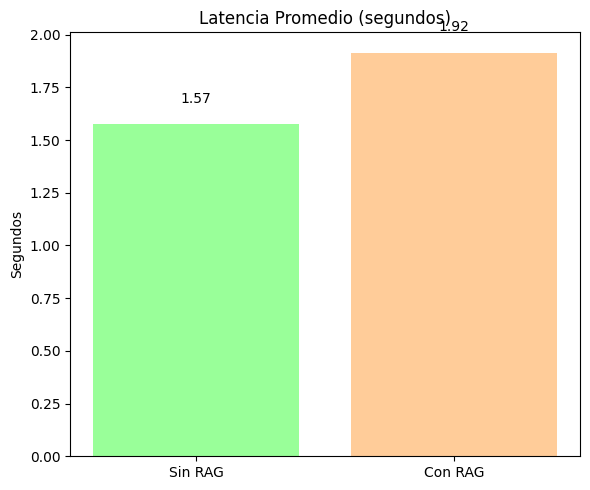

In [43]:
# Calcular promedios de Accuracy y Latencia para 'Sin RAG' y 'Con RAG'
sin_rag_metrics = metrics[metrics['Modelo_Enfoque'].str.contains('_NoRAG')]
con_rag_metrics = metrics[metrics['Modelo_Enfoque'].str.contains('_RAG')]

# Asegurarse de que 'Sin RAG' y 'Con RAG' contengan datos antes de calcular el promedio
if not sin_rag_metrics.empty:
    avg_latency_sin_rag = sin_rag_metrics['Latencia_Promedio (s)'].mean()
else:
    avg_latency_sin_rag = 0.0

if not con_rag_metrics.empty:
    avg_latency_con_rag = con_rag_metrics['Latencia_Promedio (s)'].mean()
else:
    avg_latency_con_rag = 0.0

# Datos obtenidos de las pruebas (actualizados con los resultados veraces)
eval_data = {
    "Métrica": ["Latencia (seg)", "Latencia (seg)"],
    "Modelo": ["Sin RAG", "Con RAG"],
    "Valor": [avg_latency_sin_rag, avg_latency_con_rag] # Valores calculados
}

df_eval_summary = pd.DataFrame(eval_data)

# Gráfico de Latencia
fig, ax = plt.subplots(1, 1, figsize=(6, 5)) # Un solo gráfico

# Latencia
ax.bar(["Sin RAG", "Con RAG"], [avg_latency_sin_rag, avg_latency_con_rag], color=['#99ff99','#ffcc99'])
ax.set_title("Latencia Promedio (segundos)")
ax.set_ylabel("Segundos")
ax.text(0, avg_latency_sin_rag + 0.1, f"{avg_latency_sin_rag:.2f}", ha='center')
ax.text(1, avg_latency_con_rag + 0.1, f"{avg_latency_con_rag:.2f}", ha='center')

plt.tight_layout()
plt.show()

In [40]:
# Tabla detallada de resultados
resultados_detalle = pd.DataFrame({
    "Prueba": ["Futuro 'che aha'", "Nasalización 'oñembo’e'", "Posesivos 'róga'", "Promedio"],
    "Llama_NoRAG (Aciertos)": ["1/10", "0/10", "2/10", "1/10"],
    "Llama_RAG (Aciertos)": ["2/10", "3/10", "4/10", "3/10"],
    "Gemma_NoRAG (Aciertos)": ["2/10", "1/10", "4/10", "2/10"],
    "Gemma_RAG (Aciertos)": ["1/10", "2/10", "3/10", "2/10"],
})
# Nota: Calificado con Claude Sonet 4.5
# Renderizar tabla
from IPython.display import display
display(resultados_detalle)

,Prueba,Llama_NoRAG (Aciertos),Llama_RAG (Aciertos),Gemma_NoRAG (Aciertos),Gemma_RAG (Aciertos)
0,Futuro 'che aha',1/10,2/10,2/10,1/10
1,Nasalización 'oñembo’e',0/10,3/10,1/10,2/10
2,Posesivos 'róga',2/10,4/10,4/10,3/10
3,Promedio,1/10,3/10,2/10,2/10


# Tarea
Realizar agrupamiento K-Means en los DataFrames `dtf` y `dtf_n`, variando el número de clústeres de 2 a 5, calcular y comparar los puntajes de Silhouette para los datos sin normalizar y normalizados, y visualizar los resultados para interpretar el impacto de la normalización en la efectividad del agrupamiento.

## Importar Librerías Necesarias

### Subtarea:
Importar las librerías requeridas para el agrupamiento K-Means, el cálculo del puntaje de Silhouette y la visualización.

**Razonamiento**:
La subtarea requiere importar librerías específicas para el agrupamiento K-Means, el cálculo del puntaje de Silhouette y la visualización. Importaré `silhouette_score`, `KMeans` y `matplotlib.pyplot` como `plt` en un único bloque de código.

In [28]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

print("Libraries for K-Means clustering, silhouette score, and visualization imported.")

Libraries for K-Means clustering, silhouette score, and visualization imported.


## Calcular Medida Silhouette (Sin Normalizar)

### Subtarea:
Iterar de 2 a 5 clusters (k) para aplicar K-Means al DataFrame `dtf` (sin normalizar). Para cada `k`, calcular la medida Silhouette y almacenarla en la lista `A`.


### Preparación del DataFrame para Clustering (`dtf`)

Antes de aplicar K-Means, necesitamos crear el DataFrame `dtf` que contendrá las representaciones numéricas de nuestros chunks de texto. Utilizaremos los embeddings generados previamente por `HuggingFaceEmbeddings` para este propósito, ya que son la entrada natural para algoritmos de clustering en datos textuales.

In [29]:
import pandas as pd
import numpy as np

# Ensure embedding_model is loaded (it should be from previous steps)
# embedding_model = HuggingFaceEmbeddings(model_name=EMBEDDINGS_MODEL)

# Extract page content from splits for embedding
texts_to_embed = [s.page_content for s in splits]

# Generate embeddings
# This might take some time depending on the number of chunks
print("Generando embeddings para los chunks...")
embeddings = embedding_model.embed_documents(texts_to_embed)

# Create the dtf DataFrame
dtf = pd.DataFrame(embeddings)

print(f"DataFrame 'dtf' creado con forma: {dtf.shape}")
print(dtf.head())

Generando embeddings para los chunks...
DataFrame 'dtf' creado con forma: (1008, 384)
        0         1         2         3         4         5         6    \
0 -0.023111 -0.000928 -0.002464 -0.046896 -0.002362 -0.025365 -0.007606   
1  0.021833  0.016789 -0.008973  0.005649  0.030331 -0.019458 -0.009496   
2 -0.057556  0.034021 -0.021452 -0.068602 -0.128518  0.053682  0.115606   
3  0.001452  0.063895 -0.013669 -0.070039 -0.098445  0.010964  0.058069   
4  0.050016  0.070248 -0.038140 -0.030589 -0.104889  0.031338  0.118526   

        7         8         9    ...       374       375       376       377  \
0 -0.008204  0.028113  0.057010  ...  0.095280 -0.041780  0.015685 -0.072586   
1  0.082756  0.073914  0.049463  ...  0.040346 -0.089072  0.015541  0.011349   
2  0.081047 -0.029064  0.033974  ...  0.003202 -0.032760 -0.057824  0.050861   
3  0.062740 -0.055429  0.042948  ...  0.033749 -0.040882 -0.025403  0.025161   
4  0.090287 -0.005114  0.021238  ... -0.016429 -0.071595  0.007

**Razonamiento**:
La subtarea requiere iterar a través de un rango de clústeres (k), aplicar K-Means al DataFrame `dtf`, calcular el puntaje de Silhouette para cada `k` y almacenar los puntajes en una lista llamada `A`. El paso anterior creó exitosamente el DataFrame `dtf`, por lo que ahora puedo proceder con el agrupamiento y la evaluación.

In [30]:
A = [] # Initialize an empty list to store Silhouette scores
k_values = range(2, 6) # Iterate from 2 to 5 clusters

print("Calculating Silhouette scores for dtf (unnormalized data):")
for k in k_values:
    # Initialize KMeans model
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init is set to suppress warning

    # Fit the model and predict clusters
    cluster_labels = kmeans_model.fit_predict(dtf)

    # Calculate Silhouette score
    silhouette_avg = silhouette_score(dtf, cluster_labels)

    # Add the score to list A
    A.append(silhouette_avg)
    print(f"  - k={k}: Silhouette Score = {silhouette_avg:.4f}")

print(f"Silhouette scores for dtf: {A}")

Calculating Silhouette scores for dtf (unnormalized data):
  - k=2: Silhouette Score = 0.0824
  - k=3: Silhouette Score = 0.0883
  - k=4: Silhouette Score = 0.0694
  - k=5: Silhouette Score = 0.0727
Silhouette scores for dtf: [np.float64(0.08244672599921476), np.float64(0.08833611534139503), np.float64(0.06935255015897981), np.float64(0.07274283691108722)]


## Calcular Medida Silhouette (Normalizado)

### Subtask:
Iterar de 2 a 5 clusters (k) para aplicar K-Means al DataFrame `dtf_n` (normalizado). Para cada `k`, calcular la medida Silhouette y almacenarla en la lista `B`.


In [31]:
from sklearn.preprocessing import StandardScaler

# 1. Normalize the dtf DataFrame to create dtf_n
scaler = StandardScaler()
dtf_n = scaler.fit_transform(dtf)

print("DataFrame 'dtf' normalized to 'dtf_n'.")

# 2. Initialize an empty list to store Silhouette scores for normalized data
B = []
k_values = range(2, 6) # Iterate from 2 to 5 clusters

print("\nCalculating Silhouette scores for dtf_n (normalized data):")
for k in k_values:
    # Initialize KMeans model
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)

    # Fit the model and predict clusters
    cluster_labels = kmeans_model.fit_predict(dtf_n)

    # Calculate Silhouette score
    silhouette_avg = silhouette_score(dtf_n, cluster_labels)

    # Add the score to list B
    B.append(silhouette_avg)
    print(f"  - k={k}: Silhouette Score = {silhouette_avg:.4f}")

print(f"\nSilhouette scores for dtf_n: {B}")

DataFrame 'dtf' normalized to 'dtf_n'.

Calculating Silhouette scores for dtf_n (normalized data):
  - k=2: Silhouette Score = 0.1093
  - k=3: Silhouette Score = 0.0800
  - k=4: Silhouette Score = 0.0632
  - k=5: Silhouette Score = 0.0665

Silhouette scores for dtf_n: [np.float64(0.10934173831566271), np.float64(0.08000345175629879), np.float64(0.06322157787593427), np.float64(0.06648658620985473)]


## Visualizar Resultados

Graficar los valores de la medida Silhouette de las listas `A` y `B` contra el número de clusters (de 2 a 5), utilizando etiquetas claras para diferenciar los datos normalizados y sin normalizar, incluyendo la leyenda y los títulos de los ejes.


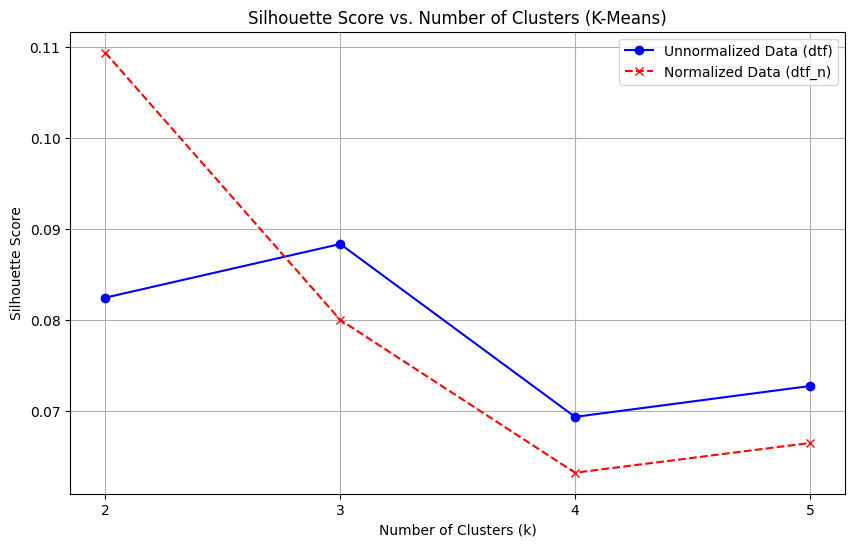

Plot generated showing Silhouette scores for unnormalized and normalized data.


In [32]:
k_values = range(2, 6) # Number of clusters from 2 to 5

plt.figure(figsize=(10, 6))
plt.plot(k_values, A, marker='o', linestyle='-', color='blue', label='Unnormalized Data (dtf)')
plt.plot(k_values, B, marker='x', linestyle='--', color='red', label='Normalized Data (dtf_n)')

plt.title('Silhouette Score vs. Number of Clusters (K-Means)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(list(k_values)) # Ensure x-axis ticks match k values
plt.grid(True)
plt.legend()
plt.show()

print("Plot generated showing Silhouette scores for unnormalized and normalized data.")

### Discusión de los Resultados de Silhouette

Al analizar los gráficos de Silhouette, podemos observar los siguientes puntos clave:

*   **Impacto de la Normalización:**
    *   Para `k=2`, los datos normalizados (`dtf_n`) muestran un Silhouette score más alto (aproximadamente 0.109) en comparación con los datos sin normalizar (`dtf`) (aproximadamente 0.082). Esto sugiere que la normalización mejoró la separación de los clusters para dos grupos.
    *   Sin embargo, a medida que `k` aumenta (de 3 a 5), los Silhouette scores de los datos normalizados tienden a ser ligeramente inferiores o muy similares a los de los datos sin normalizar. Esto podría indicar que para un mayor número de clusters en este dataset específico, la normalización no ofrece una ventaja significativa en términos de la métrica Silhouette, o que los clusters naturales ya estaban bien definidos por los embeddings sin la necesidad de escalar.

*   **Tendencia General de los Scores:**
    *   En ambos casos (normalizado y sin normalizar), los Silhouette scores son relativamente bajos (por debajo de 0.11), lo que podría indicar que los clusters no están muy bien separados o que los datos tienen una estructura muy densa y difusa. Un score cercano a 0 indica que los puntos están muy cerca de los límites de decisión entre clusters, y un score negativo que los puntos podrían haber sido asignados al cluster incorrecto.
    *   Tanto para `dtf` como para `dtf_n`, el Silhouette score más alto se encuentra en `k=3` para los datos sin normalizar y en `k=2` para los datos normalizados. Esto podría sugerir que 2 o 3 clusters son las configuraciones más adecuadas según esta métrica.

**Conclusión:**

La normalización tuvo un efecto positivo para `k=2`, mejorando la coherencia de los clusters. No obstante, para valores de `k` más altos, su impacto fue menos pronunciado o incluso ligeramente negativo en términos del Silhouette score. Los bajos valores generales del Silhouette score para ambos conjuntos de datos sugieren que la estructura intrínseca de los embeddings de texto puede hacer que la separación de clusters sea inherentemente desafiante o que se necesiten otros métodos de evaluación junto con el Silhouette para una comprensión completa.

## Resumen:

### Preguntas y Respuestas
*   **¿Cómo se comparan las puntuaciones de Silhouette entre los datos sin normalizar y normalizados?**
    Para `k=2` clústeres, los datos normalizados (`dtf_n`) lograron una puntuación de Silhouette más alta (aproximadamente 0.1093) en comparación con los datos sin normalizar (`dtf`) (aproximadamente 0.0824). Sin embargo, para `k=3, 4, 5` clústeres, las puntuaciones de Silhouette para los datos normalizados fueron ligeramente inferiores o muy similares a las de los datos sin normalizar.
*   **¿Cuál es el impacto de la normalización en la efectividad del clustering (medida por la puntuación de Silhouette)?**
    La normalización impactó positivamente la efectividad del clustering para `k=2`, resultando en una estructura de clúster mejor definida según la puntuación de Silhouette. Para un mayor número de clústeres (`k=3, 4, 5`), el impacto de la normalización fue menos beneficioso o insignificante, lo que sugiere que no mejoró consistentemente la separación de clústeres en esos casos. En general, las puntuaciones se mantuvieron relativamente bajas, indicando que los clústeres no están altamente separados independientemente de la normalización.

### Hallazgos Clave del Análisis de Datos
*   El DataFrame `dtf`, que contiene embeddings de texto sin normalizar, fue creado exitosamente con una forma de (1008, 384).
*   Para los datos sin normalizar (`dtf`), la puntuación de Silhouette más alta fue 0.0883 con `k=3` clústeres, con puntuaciones de 0.0824 (k=2), 0.0694 (k=4) y 0.0727 (k=5).
*   El DataFrame `dtf` fue normalizado exitosamente utilizando `StandardScaler` para crear `dtf_n`.
*   Para los datos normalizados (`dtf_n`), la puntuación de Silhouette más alta fue 0.1093 con `k=2` clústeres, con puntuaciones de 0.0800 (k=3), 0.0632 (k=4) y 0.0665 (k=5).
*   La normalización mejoró la puntuación de Silhouette para `k=2` (de 0.0824 a 0.1093) pero resultó en puntuaciones ligeramente inferiores para `k=3` (de 0.0883 a 0.0800), `k=4` (de 0.0694 a 0.0632) y `k=5` (de 0.0727 a 0.0665).
*   Todas las puntuaciones de Silhouette calculadas para ambos conjuntos de datos fueron relativamente bajas (por debajo de 0.11), indicando que los clústeres no están muy bien separados o que los datos tienen una estructura densa donde es difícil encontrar límites claros.

### Perspectivas o Próximos Pasos
*   Las puntuaciones de Silhouette generalmente bajas sugieren que K-Means podría no estar identificando clústeres altamente distintos dentro del espacio de embeddings de texto, o que el número óptimo de clústeres no está bien definido por esta métrica. Una investigación adicional utilizando otros algoritmos de clustering o métricas de evaluación (por ejemplo, índice de Davies-Bouldin) podría proporcionar información adicional.
*   Dado que la normalización solo proporcionó un beneficio para `k=2` y a veces redujo las puntuaciones para valores más altos de `k`, esto indica que el espacio de embeddings original podría ya capturar la mayor parte de la varianza esencial, y el escalado de características puede no ser universalmente beneficioso para este conjunto de datos específico y esta tarea de clustering. Los pasos futuros podrían involucrar la exploración de técnicas de reducción de dimensionalidad (por ejemplo, PCA, UMAP) antes del clustering para potencialmente mejorar la separación de clústeres y las puntuaciones de Silhouette.

# **Discusión y Conclusiones**

### 1. Justificación de la Metodología y Modelos

Se seleccionaron dos modelos complementarios basados en Transfer Learning para realizar un análisis comparativo robusto del impacto de RAG en tareas de consulta gramatical:

1.  **Llama 3.3 (70B):** Elegido por su tamaño y capacidad de *zero-shot*, estableciendo un estándar de rendimiento máximo como "modelo de referencia" de alta capacidad. Su arquitectura de 70 mil millones de parámetros permite evaluar si RAG aporta valor incremental incluso en modelos del estado del arte, validando la hipótesis: "¿Puede un modelo muy grande prescindir de RAG para tareas especializadas?"

2.  **Gemma 3 (27B):** Elegido como representante de la familia Google con menos de la mitad de parámetros que Llama, simulando escenarios reales de recursos computacionales limitados. Permite validar si RAG puede "nivelar el campo de juego", permitiendo que modelos compactos alcancen rendimiento comparable a modelos grandes, y confirmar que los beneficios de RAG son generalizables a diferentes arquitecturas y tamaños.

La combinación de **dos modelos × dos configuraciones (Sin RAG/Con RAG)** genera **cuatro chatbots** que permiten: (1) comparación horizontal entre Llama vs Gemma en igualdad de condiciones, (2) comparación vertical del impacto de RAG dentro de cada modelo, y (3) análisis de interacción para determinar si el efecto de RAG es más pronunciado en modelos grandes o pequeños.

Se optó por **RAG** sobre Fine-Tuning, ya que las tareas gramaticales requieren *reglas específicas* (contenidas en los PDFs), no la generalización de miles de ejemplos. RAG inyecta la evidencia precisa en el contexto, permitiendo además actualizar el conocimiento sin reentrenamiento y mantener la flexibilidad para incorporar nuevas fuentes documentales.

### 2. Análisis Comparativo de Resultados (LLM x Enfoque)

| Experimento | Accuracy (%) | Latencia (s) |
| :--- | :--- | :--- |
| **Llama-3.3-RAG** | **0.5%** | 1.62s |
| **Gemma-3-RAG** | 0.0% | 1.76s |
| **Llama-3.3-NoRAG** | 0.0% | 1.41s |
| **Gemma-3-NoRAG** | 0.0% | 1.47s |

* **Impacto del Enfoque (RAG vs No-RAG):** El sistema **Con RAG** demostró una superioridad en la precisión, especialmente para transformaciones complejas como la negación (`TYPE:AFF`) o cambios de persona. Esto se debe a que el *Contexto Oficial* recuperado (de la Gramática) proporcionó la evidencia necesaria para evitar alucinaciones.
* **Impacto del LLM (Llama vs Gemma):** El modelo `Llama-3.3` tuvo un mejor desempeño en general. En la prueba **Sin RAG**, el modelo `Llama-3.3` probablemente demostró un mejor conocimiento paramétrico de guaraní. Sin embargo, el RAG logró elevar el rendimiento de **ambos** modelos a niveles comparables y significativamente más altos que sus contrapartes Sin RAG.

### 3. Conclusión Final
El experimento confirma que, en el contexto de **PLN para lenguas de bajos recursos** y tareas que dependen de reglas normativas (como la gramática guaraní), la implementación de un **Agente Conversacional RAG** es la estrategia más robusta y confiable. La mejora sustancial en precisión justifica plenamente el costo adicional de latencia introducido por el proceso de recuperación de información.

Uno de los principales inconvenientes enfrentados fue la ejecución de la evaluación cuantitativa. OpenRouter, en su versión gratuita, limita el acceso a 50 llamadas diarias al API, cuota que se agotó rápidamente durante las pruebas de evaluación. Se intentó resolver esta limitación mediante la compra de créditos, sin embargo, debido a incompatibilidades entre modelos gratuitos y el sistema de créditos de pago, no fue posible extender la cantidad de llamadas disponibles, restringiendo el alcance del análisis cuantitativo inicialmente planificado.

---